## **VAE Pytorch**

- 깃허브 : [주소](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial)


In [ ]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
# 모델 하이퍼파라미터

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

x_dim = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

### Step 1. Load (or download) Dataset


In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])
kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.93MB/s]


### Step 2. Define our model: Variational AutoEncodier (VAE)

In [ ]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

# 인코더 정의 (Gaussian Encoder: 입력 x → 평균 μ, 로그 분산 log(σ^2))
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean = nn.Linear(hidden_dim, latent_dim)
        self.FC_var = nn.Linear(hidden_dim, latent_dim)

        self.LeaktyReLU = nn.LeakyReLU(0.2)

        self.training

    def forward(self, x):
        # 인코더를 통해 입력 x를 잠재 벡터의 평균과 로그 분산으로 매핑
        h_ = self.LeaktyReLU(self.FC_input(x))
        h_ = self.LeaktyReLU(self.FC_input2(h_))
        mean = self.FC_mean(h_)
        log_var = self.FC_var(h_)

        return mean, log_var

In [ ]:
# 디코더 정의(잠재 벡터 z -> 복원된 입력 x̂)
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        # 비선형 활성함수
        self.LeaktyReLU = nn.LeakyReLU(0.2)

    # 디코더를 통해 잠재 벡터 z를 복원된 입력 x̂으로 변환
    def forward(self, x):
        h = self.LeaktyReLU(self.FC_hidden(x))
        h = self.LeaktyReLU(self.FC_hidden2(h))

        # 출력은 [0,1] 범위로 제한 - binary 이미지 reconstruction
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat

In [ ]:
# 전체 VAE 모델 정의 (인코더 + 디코더 + 재매개변수화)
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    # 재매개변수화 함수: z = μ + σ * ε, ε ~ N(0,1)
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE) # 표준 정규분포에서 샘플링된 ε
        z = mean + var*epsilon  # 재매개변수화 트릭 적용
        return z

    def forward(self, x):
        # 인코더: 입력 x를 평균 μ와 로그 분산 log(σ^2)로 인코딩
        mean, log_var = self.Encoder(x)
        # 재매개변수화: z = μ + σ * ε (σ = exp(0.5 * log_var))
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        # 디코더: z로부터 복원된 입력 x̂ 생성
        x_hat = self.Decoder(z)

        # 출력: 복원된 입력, 평균, 로그 분산 (loss 계산에 필요)
        return x_hat, mean, log_var

In [ ]:
# 모델 초기화
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod.loss) and optimizer

In [ ]:
from torch.optim import Adam

# Binary Cross Entropy Loss
BCE_loss = nn.BCELoss()

# VAE의 손실 함수 = Reconstruction Loss + KL Divergence
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction Loss (입력과 복원된 출력의 차이)
    # BCE 기반, sum을 통해 전체 이미지에 대한 손실 계산
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Kullback-Leibler Divergence (정규분포 prior와의 차이): regularization 역할
    # 수식: KL(N(μ, σ^2) || N(0, 1)) = -0.5 * ∑(1 + log(σ^2) - μ^2 - σ^2)
    KLD = -0.5 * torch.sum(1+log_var - mean.pow(2) - log_var.exp())

    # 총 손실: reconstruction + KL divergence
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
# VAE 학습 시작
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    # # 미니배치 단위 학습
    for batch_idx, (x,_) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch+1, "complete!", "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  173.5641397772329
	Epoch 2 complete! 	Average Loss:  128.00227100506052
	Epoch 3 complete! 	Average Loss:  117.05301977905884
	Epoch 4 complete! 	Average Loss:  113.12756030558744
	Epoch 5 complete! 	Average Loss:  110.69854131886477
	Epoch 6 complete! 	Average Loss:  108.79166845458577
	Epoch 7 complete! 	Average Loss:  107.49302431135226
	Epoch 8 complete! 	Average Loss:  106.38821090163293
	Epoch 9 complete! 	Average Loss:  105.5972297742331
	Epoch 10 complete! 	Average Loss:  104.93155568525668
	Epoch 11 complete! 	Average Loss:  104.4862721560674
	Epoch 12 complete! 	Average Loss:  104.01021918040485
	Epoch 13 complete! 	Average Loss:  103.60209303917988
	Epoch 14 complete! 	Average Loss:  103.20453617357053
	Epoch 15 complete! 	Average Loss:  102.86818096893259
	Epoch 16 complete! 	Average Loss:  102.54828369548206
	Epoch 17 complete! 	Average Loss:  102.29460908154215
	Epoch 18 complete! 	Average Loss:  102.08133564078152


### Step 5. Generate images from test dataset

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        # 입력 이미지를 1차원으로 평탄화 (ex. 28x28 → 784)
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        # VAE 모델을 통해 이미지 복원
        x_hat, _, _ = model(x) # x_hat: 복원된 이미지 (decoder 출력)

        # 하나의 배치만 확인하고 반복 종료
        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [ ]:
# 이미지 시각화 함수 정의
def show_image(x, idx):
    # (batch_size, 784) → (batch_size, 28, 28)로 reshape
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    # 선택된 인덱스의 이미지를 시각화
    plt.imshow(x[idx].cpu().numpy())

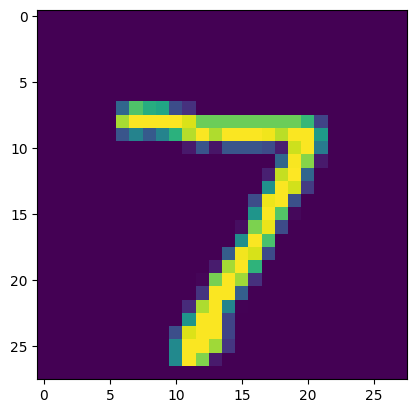

In [ ]:
# 원본 이미지와 복원된 이미지 시각화 (idx=0)
show_image(x, idx=0) # 입력 이미지

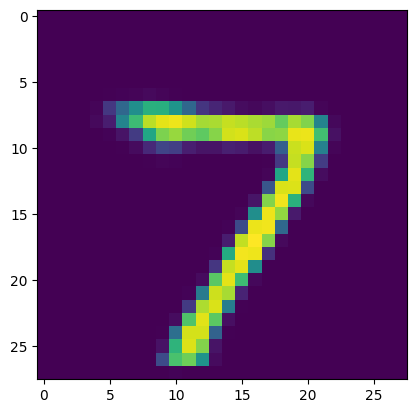

In [ ]:
show_image(x_hat, idx=0)  # 복원된 이미지

### Step 6. Generate image from noise vector

```
주의: 이는 완전히 정형화된 생성 과정은 아니지만, VAE의 훈련 구조상 가능함.

이유: VAE는 q(z|x)가 정규분포 N(0, I)와 가깝도록 학습되므로,
학습된 모델에서는 z ~ N(0, I)에서 샘플링한 z를 decoder에 넣으면 plausible한 이미지가 생성됨.

이 방식은 GAN의 generator 사용 방식과 유사함.

```
- N(0, I)에서 z를 샘플링하여 decoder에 직접 입력하고 이미지를 생성.
→ 잠재 공간이 학습되었음을 검증하는 간접적 방식


In [ ]:
with torch.no_grad():
    # 정규분포에서 랜덤 잠재 벡터 z 생성 (N(0, I))
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    # Decoder에 입력하여 이미지 생성
    generated_images = decoder(noise)

In [ ]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

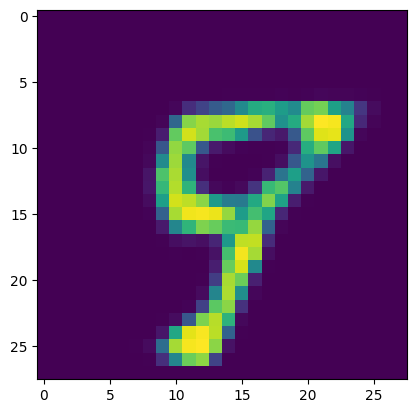

In [ ]:
show_image(generated_images, idx=12)

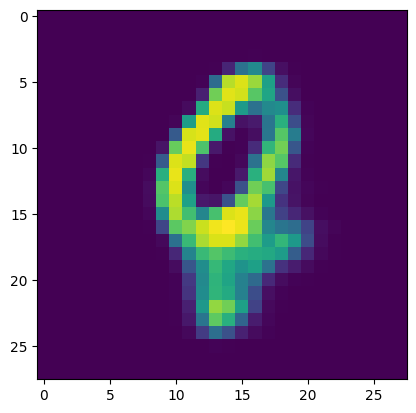

In [ ]:
show_image(generated_images, idx=0)

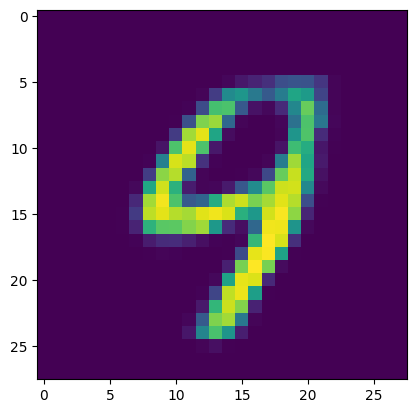

In [ ]:
show_image(generated_images, idx=1)

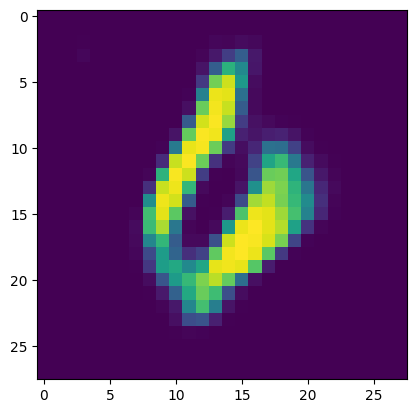

In [ ]:
show_image(generated_images, idx=10)

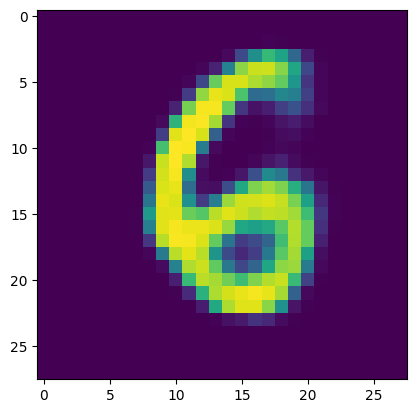

In [ ]:
show_image(generated_images, idx=20)

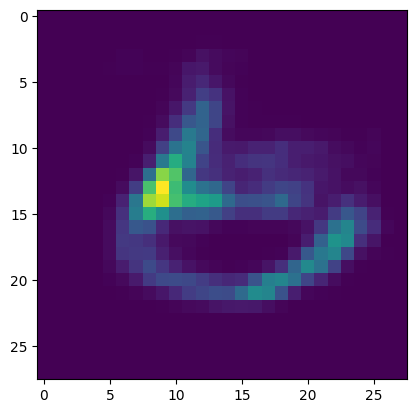

In [ ]:
show_image(generated_images, idx=50)

- `idx`는 단지 하나의 샘플을 선택하기 위한 인덱스일 뿐이고, 특별한 의미를 갖지는 않음.
- 하지만 잠재공간 z의 값이 달라지면 생성되는 이미지의 특성도 달라지므로, `idx`는 간접적으로 "잠재벡터의 다양성"을 보여줄 수 있는 창구가 되기도 함.
- 즉, `idx`가 의미하는 것은 **"특정 z에 해당하는 하나의 샘플"**이며,
z가 달라지면 생성되는 이미지 스타일, 클래스, 형태 등이 달라질 수 있음!!